In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# prompt: install tim

!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Dataset
class AccidentDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for label, folder in enumerate(['Non Accident', 'Accident']):
            folder_path = os.path.join(self.data_dir, folder)
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                images.append(img_path)
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = '/content/drive/MyDrive/datasetcap2/road_accident_dataset/'
full_train_dataset = AccidentDataset(data_dir + 'train', transform=transform)
val_dataset = AccidentDataset(data_dir + 'val', transform=transform)
test_dataset = AccidentDataset(data_dir + 'test', transform=transform)

# Use 10% of the dataset for training (to reduce memory and time)
train_size = int(0.2 * len(full_train_dataset))
train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])

# DataLoaders with Reduced Batch Size
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the CNN Model without SE Blocks
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),   # Output: (64, 224, 224)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Output: (64, 112, 112)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: (128, 112, 112)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Output: (128, 56, 56)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # Output: (256, 56, 56)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   # Output: (256, 28, 28)
        )

        # Calculate the correct input size for the Linear layer
        self.feature_size = self._get_feature_size()

        # Creating the classifier with the correct input size
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_size, 1024),  # Use the calculated feature size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    def _get_feature_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)  # A dummy input with the expected input shape
            dummy_output = self.cnn(dummy_input)
            return dummy_output.view(1, -1).size(1)  # Flatten and get the size

    def forward(self, x):
        x = self.cnn(x)
        x = self.classifier(x)
        return x

# Initialize the Model
model = SimpleCNN()
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training, Validation, and Testing
num_epochs = 10
history_cnn = {
    'train_losses': [],
    'val_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'test_accuracies': [],
}

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()

    history_cnn['train_losses'].append(running_loss / len(train_loader))
    history_cnn['train_accuracies'].append(correct / len(train_loader.dataset))

    model.eval()
    val_running_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    history_cnn['val_losses'].append(val_running_loss / len(val_loader))
    history_cnn['val_accuracies'].append(val_correct / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {history_cnn["train_losses"][-1]:.4f}, Val Loss: {history_cnn["val_losses"][-1]:.4f}, Train Acc: {history_cnn["train_accuracies"][-1]:.4f}, Val Acc: {history_cnn["val_accuracies"][-1]:.4f}')

# Save the model and history
model_path = f'/content/drive/MyDrive/cnn_finetuned.pth'
torch.save(model.state_dict(), model_path)

history_path = f'/content/drive/MyDrive/cnn_history.pth'
torch.save(history_cnn, history_path)


Epoch 1/10, Train Loss: 39.9135, Val Loss: 50.5380, Train Acc: 0.5443, Val Acc: 0.5408
Epoch 2/10, Train Loss: 15.3101, Val Loss: 19.9583, Train Acc: 0.7089, Val Acc: 0.6429
Epoch 3/10, Train Loss: 20.8440, Val Loss: 14.5381, Train Acc: 0.6139, Val Acc: 0.6531
Epoch 4/10, Train Loss: 18.6150, Val Loss: 10.6241, Train Acc: 0.6203, Val Acc: 0.6531
Epoch 5/10, Train Loss: 14.5510, Val Loss: 13.3685, Train Acc: 0.6329, Val Acc: 0.6531
Epoch 6/10, Train Loss: 9.2414, Val Loss: 7.0632, Train Acc: 0.7025, Val Acc: 0.7143
Epoch 7/10, Train Loss: 13.3308, Val Loss: 4.5012, Train Acc: 0.6899, Val Acc: 0.7245
Epoch 8/10, Train Loss: 9.1522, Val Loss: 7.9954, Train Acc: 0.6709, Val Acc: 0.6837
Epoch 9/10, Train Loss: 5.0271, Val Loss: 3.1936, Train Acc: 0.7025, Val Acc: 0.7041
Epoch 10/10, Train Loss: 3.0024, Val Loss: 5.2264, Train Acc: 0.7911, Val Acc: 0.6633


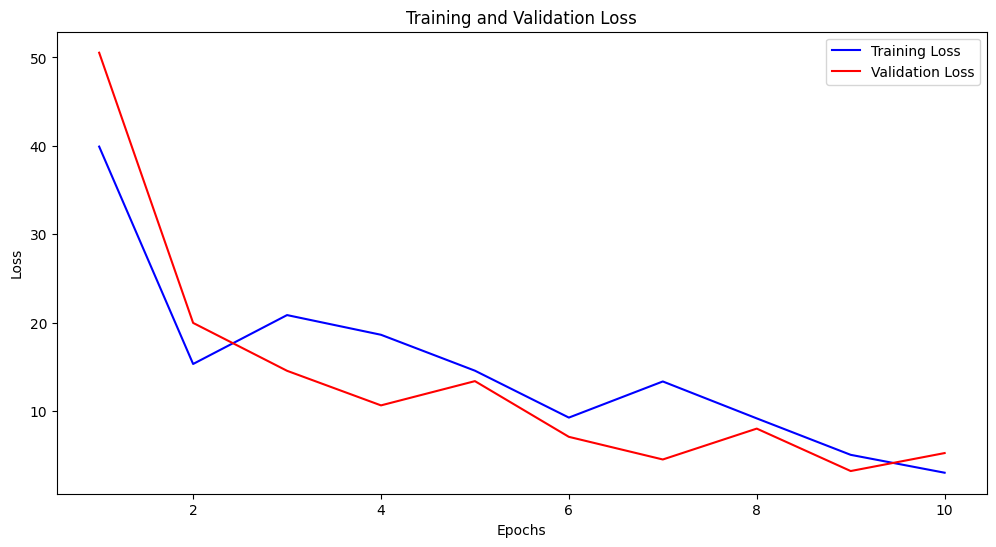

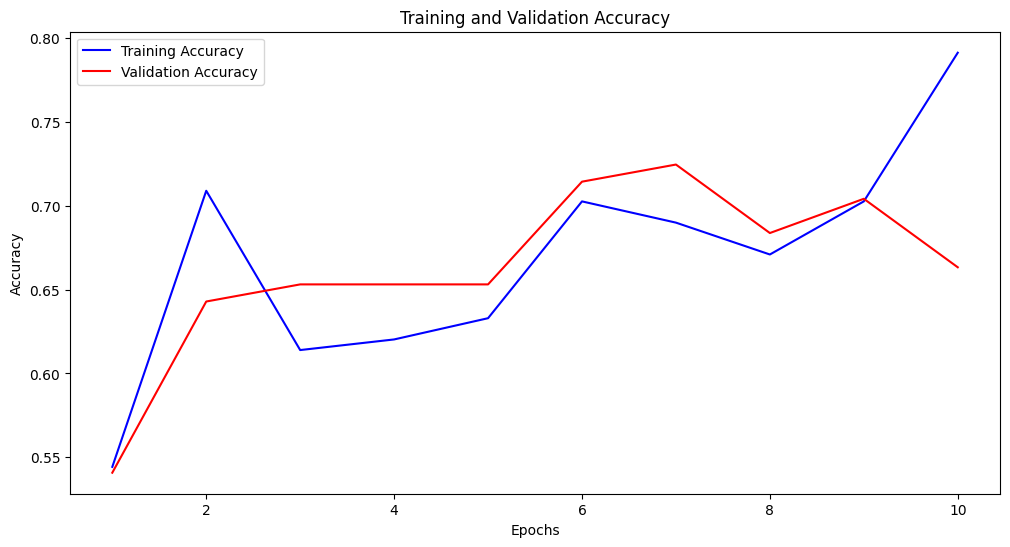

Classification Report:
              precision    recall  f1-score   support

Non Accident       0.69      0.65      0.67        52
    Accident       0.63      0.67      0.65        46

    accuracy                           0.66        98
   macro avg       0.66      0.66      0.66        98
weighted avg       0.67      0.66      0.66        98



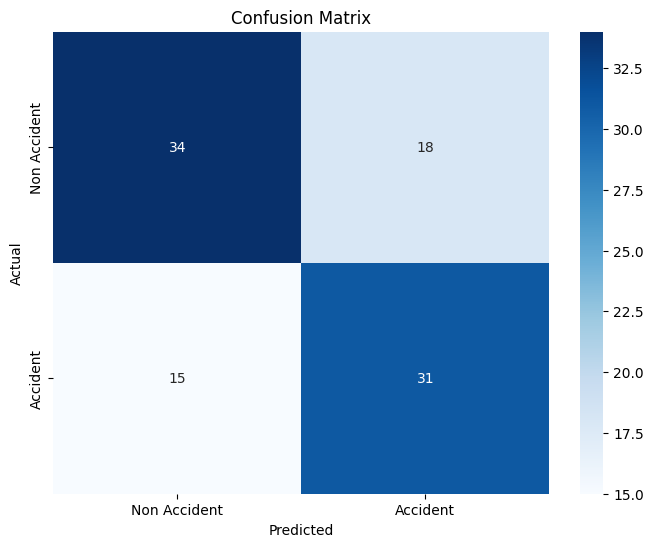

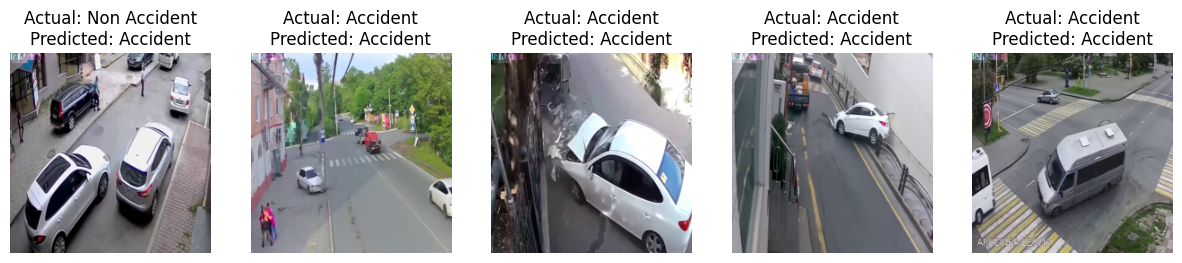

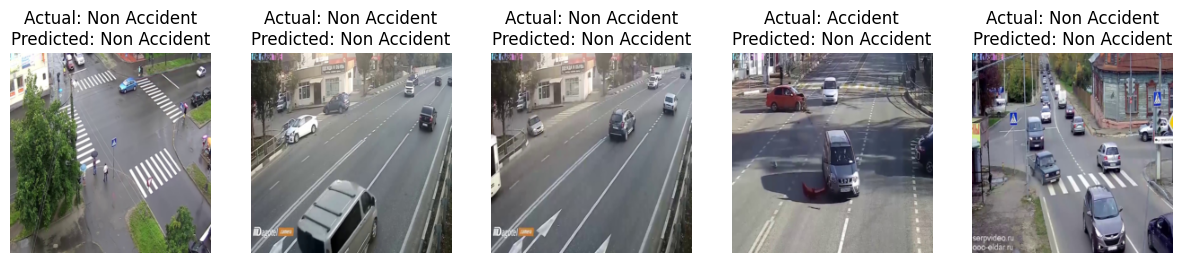

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load the saved history
history_cnn = torch.load('/content/drive/MyDrive/cnn_history.pth')

# Plotting Accuracy and Loss Graphs
def plot_metrics(history):
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_losses'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_losses'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_accuracies'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracies'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history_cnn)

# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/cnn_finetuned.pth'))
model = model.to(device)

# Generate Predictions on the Validation Set
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non Accident', 'Accident']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non Accident', 'Accident'], yticklabels=['Non Accident', 'Accident'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize Predictions on the Validation Set
def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    accident_images = []
    non_accident_images = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(preds)):
                if preds[i] == 1 and len(accident_images) < num_images:
                    accident_images.append((inputs[i].cpu(), labels[i], preds[i]))
                elif preds[i] == 0 and len(non_accident_images) < num_images:
                    non_accident_images.append((inputs[i].cpu(), labels[i], preds[i]))

                if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                    break
            if len(accident_images) >= num_images and len(non_accident_images) >= num_images:
                break

    # Plot Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: {"Accident" if actual == 1 else "Non Accident"}\nPredicted: {"Accident" if predicted == 1 else "Non Accident"}')
        plt.axis('off')
    plt.show()

    # Plot Non Accident Images
    plt.figure(figsize=(15, 5))
    for idx, (img, actual, predicted) in enumerate(non_accident_images):
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f'Actual: {"Accident" if actual == 1 else "Non Accident"}\nPredicted: {"Accident" if predicted == 1 else "Non Accident"}')
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_loader, num_images=5)
